In [ ]:
import pandas as pd
import numpy as np

# Inisialisasi Populasi

* Sigma P2 hingga PD dibangkitkan secara random dengan range yang ditetapkan sehingga populasi awal memenuhi kendala pertidaksamaan lower dan upper bound pembangkit listrik

In [ ]:
def Initialize(N:int, D:int, Pd:float ,max:np.array, min:np.array):
    X = []
    for i in range(D):
        x = np.random.uniform(low = min[i], high = max[i], size = N)
        X.append(x)
    X = np.transpose(X)
    return X

# Fitness and Objective

Tujuan pada studi kasus IEEE-30 adalah meminimalisir biaya operasional 6 pembangkit listrik, namun tetap memenuhi kendala seperti persamaan beban sistem dan pertidaksamaan lower serta upper bound pembangkit listrik
* Fitness = Mininmalisir fungsi objektif
* Objektif fi: ai + bi*xi + ci*xi dengan xi adalah Pembangkit listrik ke-i



*  Fungsi Objektif Minimalisir Biaya

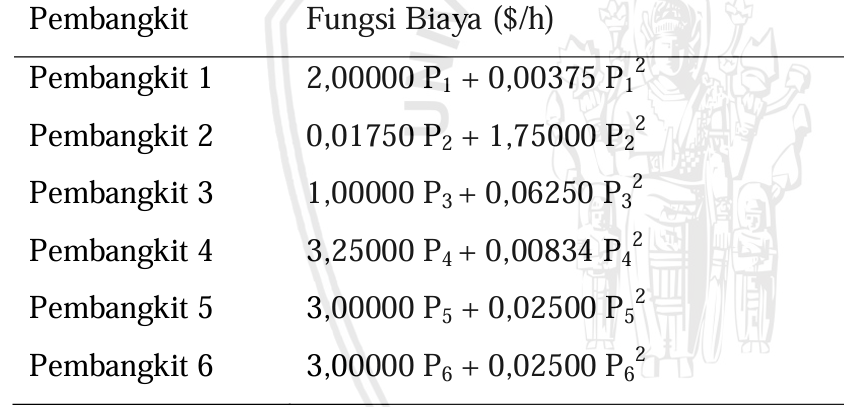

* Kendala Persamaan dan pertidaksamaan
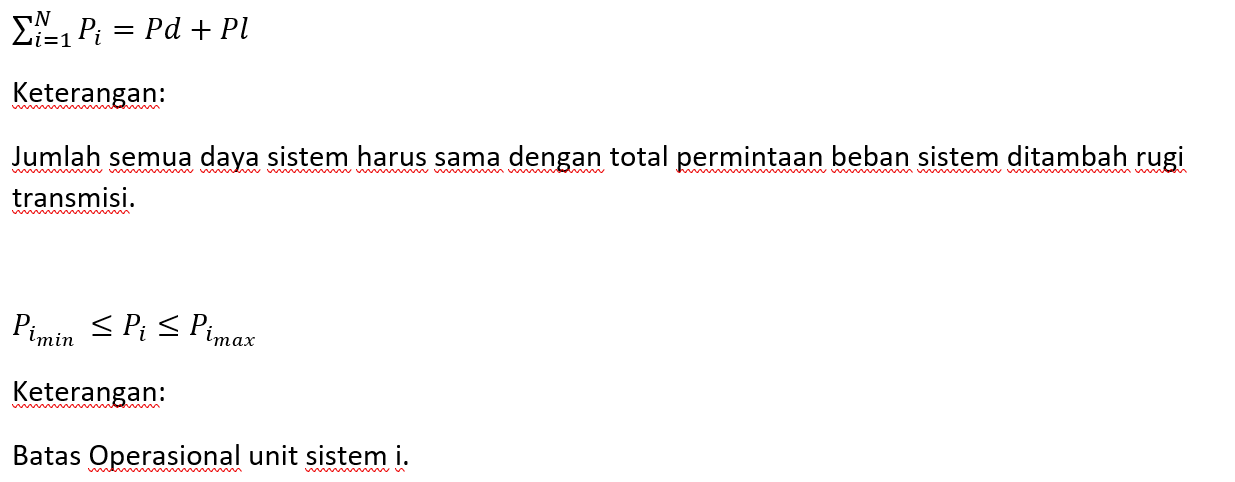

* Catatan:
Rugi transmisi asumsikan 0

In [ ]:
def Fitness(x, D, ai, bi, ci, Pmax, Pmin, Pd):
    for i in range(D):
        x[i] = max(min(x[i],Pmax[i]),Pmin[i]) #Memastikan terpenuhinya lower dan upper bound
    x[0] = Pd - np.sum(x[1:D]) #Memastikan terpenuhinya persamaan beban sistem
    if x[0]>Pmax[0] or x[0]<Pmin[0]: #Memastikan pembangkit listrik pertama tidak melewati batas
        return x, 10**10
    F = np.sum(ai + bi*x + ci*(x**2))
    return x, F

# Main Algorithm

In [ ]:
def OrcaAlgo(N, D, MaxIter, Pd, Pmax,Pmin, p1,p2,q,ai,bi,ci):
    Pop = Initialize(N,D,Pd,Pmax,Pmin)
    history = []
    FitPop = np.array([])
    M = Pd/D
    bestfit = 10**10
    bestpop = Pop
    for i in range(N):
        Pop[i], Fit = Fitness(Pop[i], D, ai, bi, ci, Pmax, Pmin, Pd)
        FitPop = np.append(FitPop,Fit)
        if bestfit>Fit:
            bestfit = Fit
            bestpop = Pop[i]

    for iterasi_t in range(MaxIter):
        random = np.random.rand(1)
        PopChase = np.zeros([N,D])
        FitChase = np.array([])

        MeanBest4 = np.mean(Pop[pd.DataFrame(FitPop,columns=['Fit']).nsmallest(4,'Fit').index],axis=0)
        for i in range(N):
          #Chasing Phase
            if random > p1:
                if random > q: #Driving Chasing Method
                    a,b,d = np.random.rand(3)
                    c = 1-b
                    vchase = (a*(d*bestpop - 2*(b*M + c*Pop[i])))
                else:
                    vchase = (2*np.random.rand(1))*bestpop - Pop[i]
                xchase = Pop[i]+vchase

            else: #Encircle Chasing Method
                u = 2*(random-0.5)*((MaxIter-iterasi_t)/MaxIter)
                xj = Pop[np.random.permutation(range(N))[:3]]
                xchase = xj[0]+u*(xj[1]-xj[2])
            xchase, Fit = Fitness(xchase, D, ai, bi, ci, Pmax, Pmin, Pd)

            if Fit<FitPop[i]:
                PopChase[i] = xchase
                FitChase = np.append(FitChase,Fit)
            else:
                PopChase[i] = Pop[i]
                FitChase = np.append(FitChase,FitPop[i])

        #Attack Phase
        for j in range(N):
            vattack1 = MeanBest4 - PopChase[j]
            MeanRandom3Chase = np.mean(PopChase[np.random.permutation(range(N))[:3]],axis=0)
            vattack2 = MeanRandom3Chase - Pop[j]
            g1 = np.random.uniform(0,2)
            g2 = np.random.uniform(-2.5,2.5)
            xattack = PopChase[j] + g1*vattack1 + g2*vattack2
            xattack, FitAttack = Fitness(xattack, D, ai, bi, ci, Pmax, Pmin, Pd)

            if FitAttack<FitChase[j]:
                Pop[j] = xattack
                FitPop[j] = FitAttack
            else:
                xattack = np.copy(PopChase[j])
                lb_index = np.random.rand(D)<p2
                xattack[lb_index] = Pmin[lb_index]
                xattack, FitAttack = Fitness(xattack, D, ai, bi, ci, Pmax, Pmin, Pd)
                if FitAttack<FitChase[j]:
                    Pop[j] = xattack
                    FitPop[j] = FitAttack
                else:
                    Pop[j] = PopChase[j]
                    FitPop[j] =FitChase[j]
        newbestfit = np.min(FitPop)
        if bestfit>newbestfit:
            bestfit = newbestfit
            bestpop = Pop[np.equal(FitPop,newbestfit)][0]
        history.append(bestfit)

    return bestpop, bestfit ,PopChase, FitChase, history

# Percobaan Study Case IEEE-30

### Daftar variabel
1. N: Jumlah Populasi Orca
2. D: Dimensi atau Banyak pembangkit listrik
3. MaxIter: Maksimum Iterasi
4. Pd: Beban Sistem
5. Pmax: Batas operasional maksimal Pembangkit [PMax1, PMax2,....,PMaxD]
6. Pmin: Batas operasional Minimal Pembangkit [PMin1, PMin2,...,PMinD]
7. p1: Probabilitas penentuan metode fase chasing
8. p2: Probabilitas pada fase attack
9. q: Probabilitas penentuan Equation metode fase chasing V_chase1

10. ai: Konstanta/biaya Fungsi objektif F (ai = [a1, a2,...], bi=[b1, b2, ....], ci = [c1,c2,...])

In [ ]:
N = 30
D = 6
MaxIter = 30
Pd = 283.4
Pmax = np.array([200, 80, 50, 35, 30, 40])
Pmin = np.array([50, 20, 15, 10, 10, 12])
p1 = 0.4
p2 = 0.05
q = 0.9

#Konstanta fungsi optimasi (biaya)
ai = np.array([0,0,0,0,0,0])
bi = np.array([2, 1.75, 1, 3.25, 3, 3])
ci = np.array([0.00375, 0.0175, 0.0625, 0.0083, 0.025, 0.025])

In [ ]:
import time
hasil15 = {'Solusi terbaik':[],'Bestcost':[],'Waktu':[],'Bestcost history':[]}
for _ in range(30):
    start_time = time.time()
    solusiterbaik, bestcost, _, _, history = OrcaAlgo(N, D, MaxIter, Pd, Pmax,Pmin, p1,p2,q,ai,bi,ci)
    stop = time.time()-start_time
    hasil15['Solusi terbaik'].append(solusiterbaik)
    hasil15['Bestcost'].append(bestcost)
    hasil15['Waktu'].append(stop)
    hasil15['Bestcost history'].append(history)

In [ ]:
print('Biaya terkecil:\n')
for i in range(30):
    print('Percobaan %d: '%(i),hasil15['Bestcost'][i])
print('Best: ',np.min(hasil15['Bestcost']))
print('Mean: ',np.mean(hasil15['Bestcost']))
print('Std: ',np.std(hasil15['Bestcost']))

print('==============================================')
print('Waktu Komputasi:\n')
for i in range(30):
    print('Percobaan %d: '%(i),round(hasil15['Waktu'][i],3),' detik')


Biaya terkecil:

Percobaan 0:  767.5981015475993
Percobaan 1:  767.5980998022698
Percobaan 2:  767.5981000543334
Percobaan 3:  767.5980999422135
Percobaan 4:  767.5981009874282
Percobaan 5:  767.5981344424405
Percobaan 6:  767.5980999504337
Percobaan 7:  767.59809984396
Percobaan 8:  767.598100490571
Percobaan 9:  767.5981016275679
Percobaan 10:  767.5980999120504
Percobaan 11:  767.5980998056208
Percobaan 12:  767.5980997792993
Percobaan 13:  767.5980997876854
Percobaan 14:  767.5980998691243
Percobaan 15:  767.5981001687719
Percobaan 16:  767.5980997826582
Percobaan 17:  767.5980999170597
Percobaan 18:  767.5980997800583
Percobaan 19:  767.5980997994926
Percobaan 20:  767.5980997823318
Percobaan 21:  767.5981000482615
Percobaan 22:  767.5980997771812
Percobaan 23:  767.5980998772759
Percobaan 24:  767.5980997768366
Percobaan 25:  767.5980997788183
Percobaan 26:  767.5980997774947
Percobaan 27:  767.5980997798009
Percobaan 28:  767.598100688678
Percobaan 29:  767.598099883389
Best:  7

## Percobaan 30x

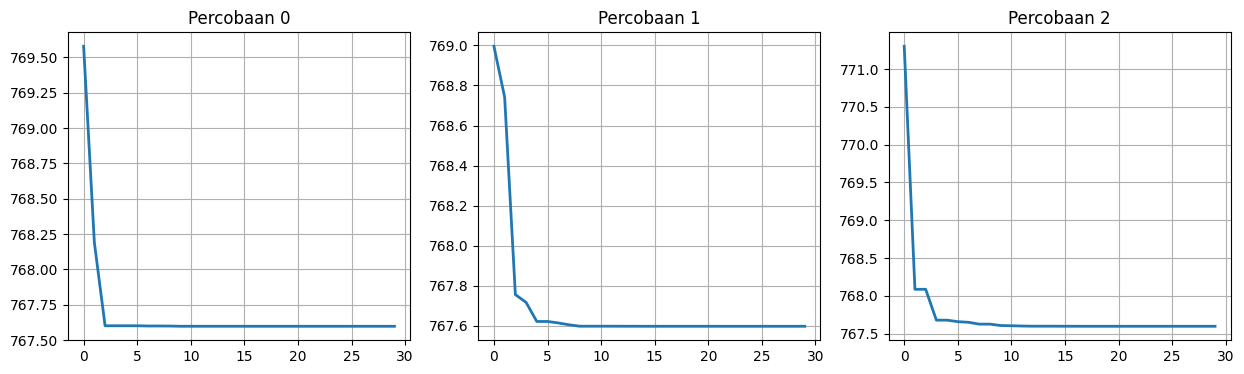

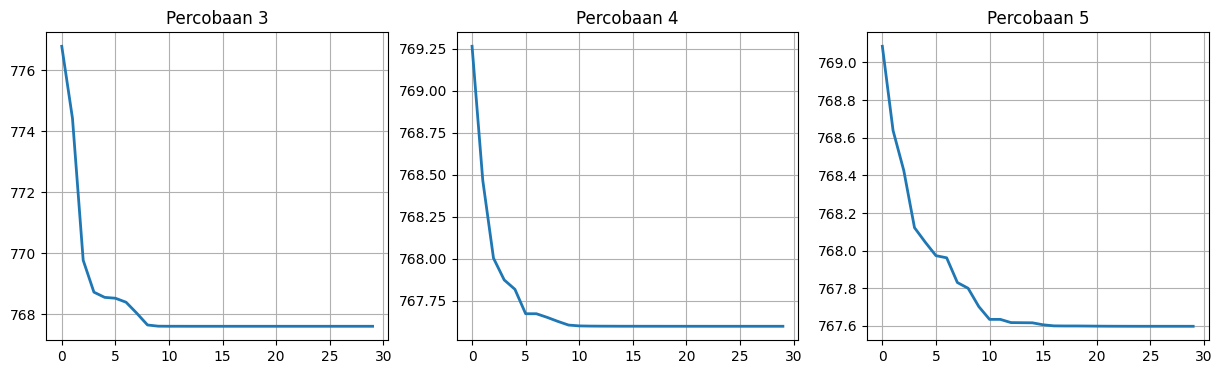

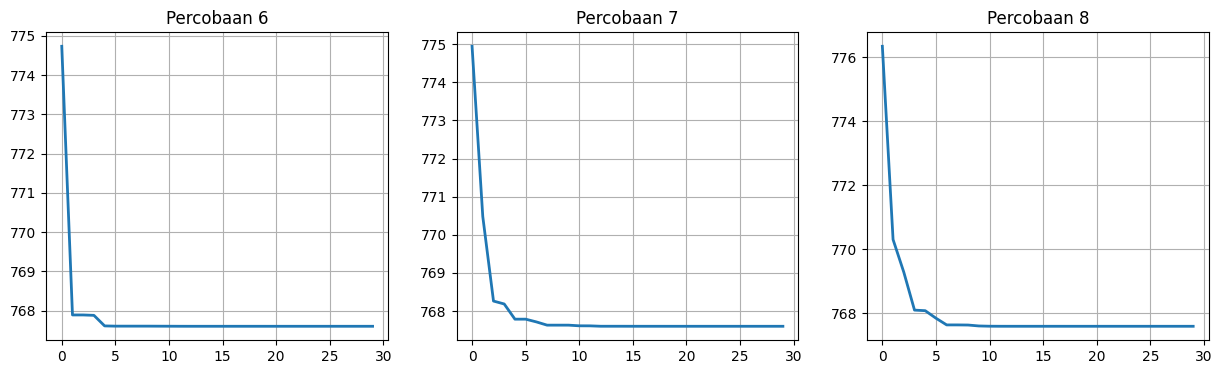

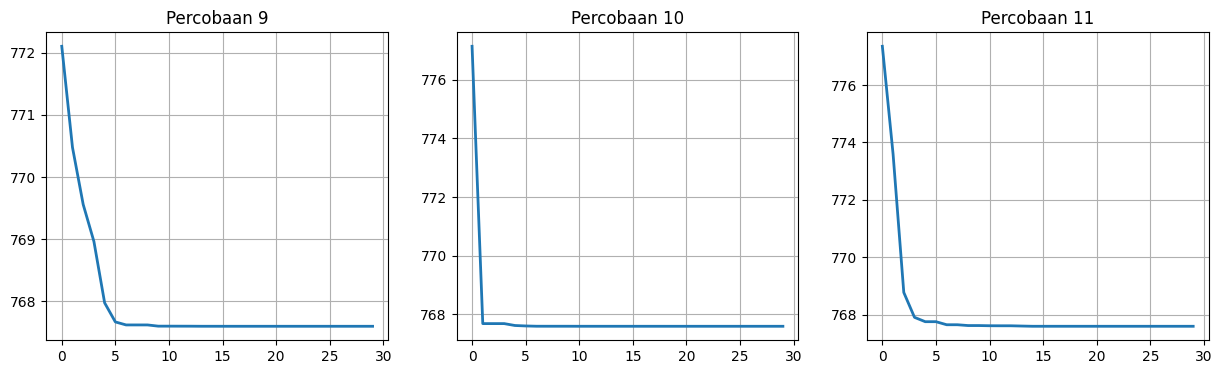

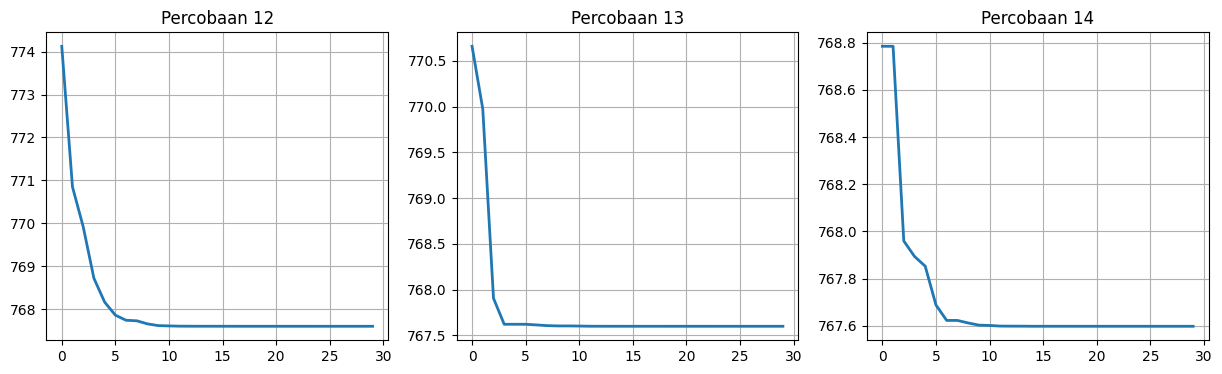

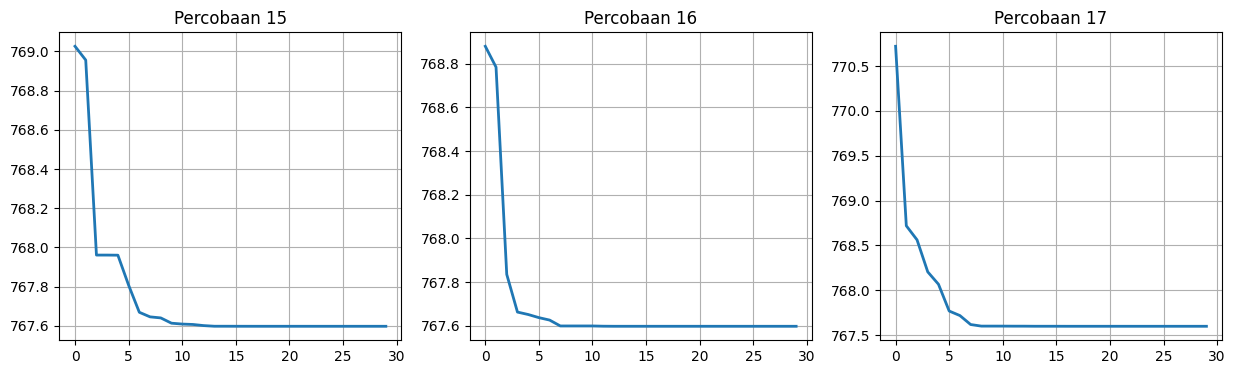

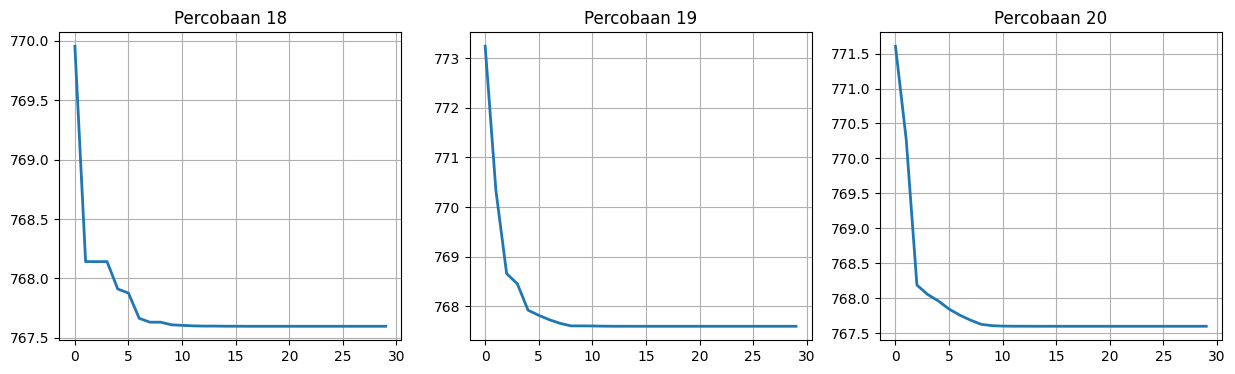

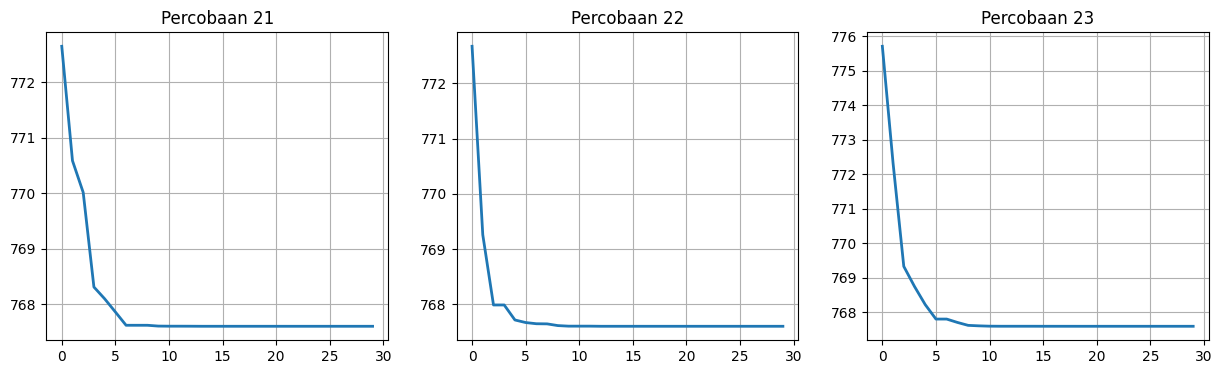

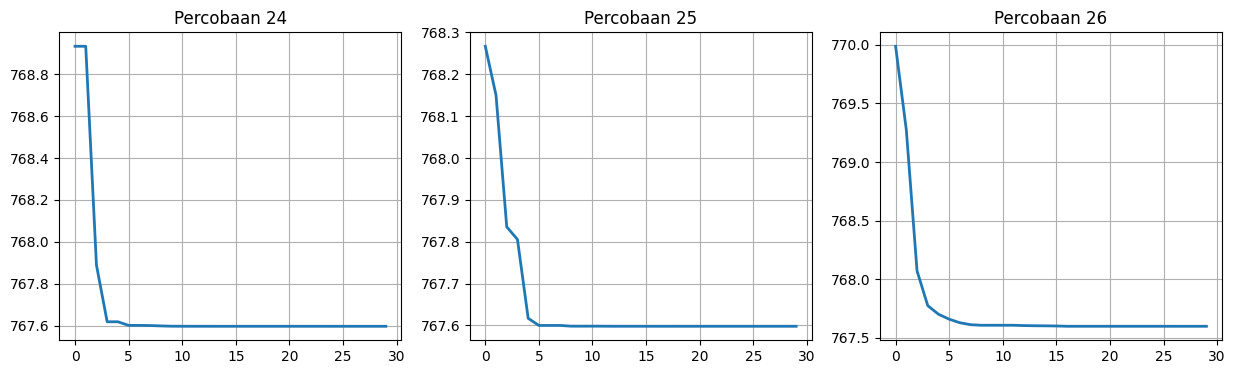

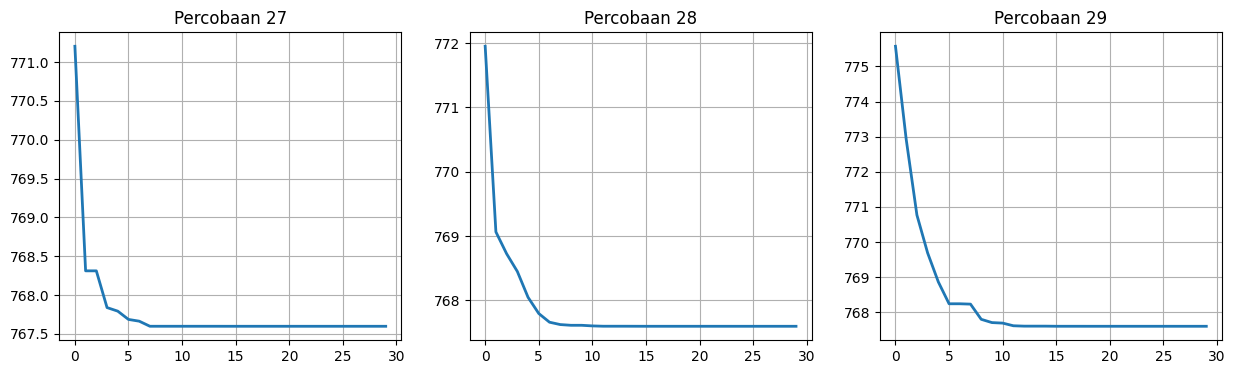

In [ ]:
import matplotlib.pyplot as plt
for i in range(0,30,3):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize = [15,4])
    ax[0].plot(hasil15['Bestcost history'][i],linewidth=2)
    ax[0].set_title('Percobaan '+str(i))
    ax[0].grid(True)
    ax[1].plot(hasil15['Bestcost history'][i+1],linewidth=2)
    ax[1].set_title('Percobaan '+str(i+1))
    ax[1].grid(True)
    ax[2].plot(hasil15['Bestcost history'][i+2],linewidth=2)
    ax[2].set_title('Percobaan '+str(i+2))
    ax[2].grid(True)
    plt.show()